# Developing the sensitivity test tools using the BNB 

## Defining the benchmark points

As this is aimed to be a comparison with the existing MicroBooNE limits, we define the same benchmark points as a starting point. They are as defined below:

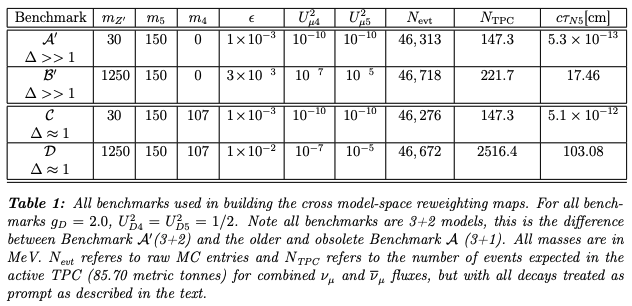

These are the parameters defined in the DarkNews $e^+e^-$ MOU, which were interested in comparing to. We should reproduce the $N_{TPC}$, from which we can then base our sensitivity testing.

In [1]:
import DarkNews as dn
from DarkNews import GenLauncher
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pyhf


In [14]:
neval = 1e4
experiment = 'microboone'
loglevel = 'WARNING'
HNL_type = 'dirac'
no_pelastic = True
decay_product = 'e+e-'

kwargs_a = {  
        'name': 'benchmark_a',
        'neval': neval,
        'HNLtype': HNL_type,
        'mzprime':0.030,
        'm5': 0.150,
        'm4': 0,
        'epsilon': 1e-3,
        "Umu4": 1e-5,
        "Umu5": 1e-5, 
        # 'unweighted_hep_events': 1000,
        # 'hep_unweight': True,
        'decay_product': decay_product,
        'experiment': experiment,
        'nopelastic': no_pelastic,
        'pandas': False,
        'loglevel': loglevel
        }

kwargs_b = {  
        'name': 'benchmark_b',
        'neval': neval,
        'HNLtype': HNL_type,
        'mzprime':1.250,
        'm5': 0.150,
        'm4': 0,
        'epsilon': 3e-3,
        "Umu4": 10**(-3.5),
        "Umu5": 10**(-2.5), 
        
        # 'unweighted_hep_events': 1000,
        # 'hep_unweight': True,
        'decay_product': decay_product,
        'experiment': experiment,
        'nopelastic': no_pelastic,
        'pandas': False,
        'loglevel': loglevel
        }

kwargs_c = {  
        'name': 'benchmark_c',
        'neval': neval,
        'HNLtype': HNL_type,
        'mzprime':0.03,
        'm5': 0.150,
        'm4': 0.107,
        'epsilon': 1e-3,
        "Umu4": 1e-5,
        "Umu5": 1e-5, 
        
        # 'unweighted_hep_events': 1000,
        # 'hep_unweight': True,
        'decay_product': decay_product,
        'experiment': experiment,
        'nopelastic': no_pelastic,
        'pandas': False,
        'loglevel': loglevel
        }

kwargs_d = {  
        'name': 'benchmark_d',
        'neval': neval,
        'HNLtype': HNL_type,
        'mzprime':1.250,
        'm5': 0.150,
        'm4': 0.107,
        'epsilon': 1e-2,
        "Umu4": 10**(-3.5),
        "Umu5": 10**(-2.5), 
        
        # 'unweighted_hep_events': 1000,
        # 'hep_unweight': True,
        'decay_product': decay_product,
        'experiment': experiment,
        'nopelastic': no_pelastic,
        'pandas': False,
        'loglevel': loglevel
        }

In [15]:
gen_object_A = GenLauncher(**kwargs_a)
gen_object_A.run()
benchmark_A = gen_object_A.df
gen_object_B = GenLauncher(**kwargs_b)
gen_object_B.run()
benchmark_B = gen_object_B.df
gen_object_C = GenLauncher(**kwargs_c)
gen_object_C.run() 
benchmark_C = gen_object_C.df
gen_object_D = GenLauncher(**kwargs_d)
gen_object_D.run()
benchmark_D = gen_object_D.df

Directory tree for this run already exists. Overriding it.
Directory tree for this run already exists. Overriding it.
Directory tree for this run already exists. Overriding it.
Directory tree for this run already exists. Overriding it.


### Using ToyAnalysis to get an idea of the expected signal rate

This is for a PoT and flux defined in src/DarkNews/include/microboone.txt.

Currently set at $6.8\times 10^{20}$ PoT.

In [16]:
### Using the analysis tools defined in ToyAnalysis for the MicroBooNE example.
# We use these tools to make selections on the generated decays to be contained within the TPC.
import ToyAnalysis as ta
import ToyAnalysis.analysis as a
import ToyAnalysis.analysis_decay as an

df1 = an.set_params(benchmark_A)

benchmark_A_decay = an.decay_selection(benchmark_A, l_decay_proper_cm = benchmark_A.attrs['N5_ctau0'], experiment='microboone')
benchmark_B_decay = an.decay_selection(benchmark_B, l_decay_proper_cm = benchmark_B.attrs['N5_ctau0'], experiment='microboone')
benchmark_C_decay = an.decay_selection(benchmark_C, l_decay_proper_cm = benchmark_C.attrs['N5_ctau0'], experiment='microboone')
benchmark_D_decay = an.decay_selection(benchmark_D, l_decay_proper_cm = benchmark_D.attrs['N5_ctau0'], experiment='microboone')

In [17]:
rate_A = sum(benchmark_A_decay.w_event_rate)
rate_B = sum(benchmark_B_decay.w_event_rate)
rate_C = sum(benchmark_C_decay.w_event_rate)
rate_D = sum(benchmark_D_decay.w_event_rate)

print(f'Rate A: {rate_A}')
print(f'Rate B: {rate_B}')
print(f'Rate C: {rate_C}')
print(f'Rate D: {rate_D}')

Rate A: 146.70571664525167
Rate B: 205.30979723985416
Rate C: 144.147844574958
Rate D: 1458.6847873401705


## Background rates
Base the background rate on the single bin rate given in the DarkNews BNB technote:
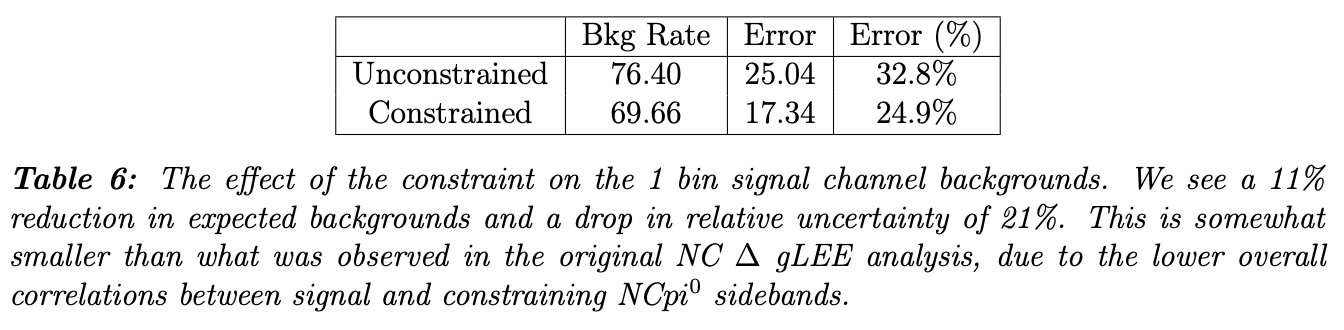

In [18]:
bkg_events = 69.66
bkg_events_tot_uncert = 17.34
bkg_uncert = bkg_events_tot_uncert / bkg_events

## Single bin histograms of signal and background

In [19]:
def get_expected_signal(df, efficiency = 0.2):
    return sum(df.w_event_rate) * efficiency

def get_tot_syst(err_arr):
    return np.sqrt(np.sum(err_arr**2))

def plot_single_bin_hist(sig, bkg, data, syst_uncert):

    data_err = np.sqrt(data)

    fig,ax = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(4,6),dpi=150)

    ax[0].step([0,1] , [bkg, bkg],  label = f'bkg = {bkg}')
    ax[0].step([0, 1] , [sig+bkg, sig+bkg], label = 'signal = {:.4}'.format(sig))


    ax[0].errorbar([0.5], [data], yerr=[data_err], fmt='o', color='black', capsize=5, label = f'Data = {data}')

    ax[0].bar([0.5], [2 * syst_uncert], width = 1, bottom=[sig+bkg - syst_uncert], hatch='/', alpha=0.25, color='none', edgecolor='r', lw=0, label = 'syst. error')
    ax[0].set_ylim(0)
    ax[0].legend()
    ax[0].set_xlabel('Tot norm')
    ax[0].set_ylabel('Events')
    
    ax[1].step([0,1] , [1, 1], color='black')
    ax[1].errorbar([0.5], [data/(bkg)], yerr=[data_err/(bkg)], fmt='o', color='black', capsize=5)
    ax[1].bar([0.5], 2*[syst_uncert/bkg]+syst_uncert/bkg, width = 1, bottom=[1 - syst_uncert/bkg], hatch='/', alpha=0.25, color='none', edgecolor='r', lw=0)
    ax[1].set_ylim(0., 2.)
    ax[1].set_ylabel('Data/MC')
    return fig, ax

/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_59206/2359554345.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


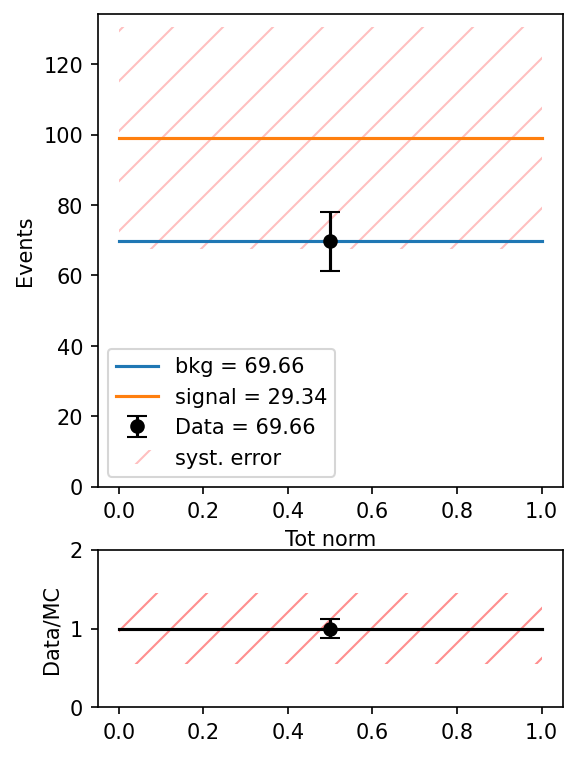

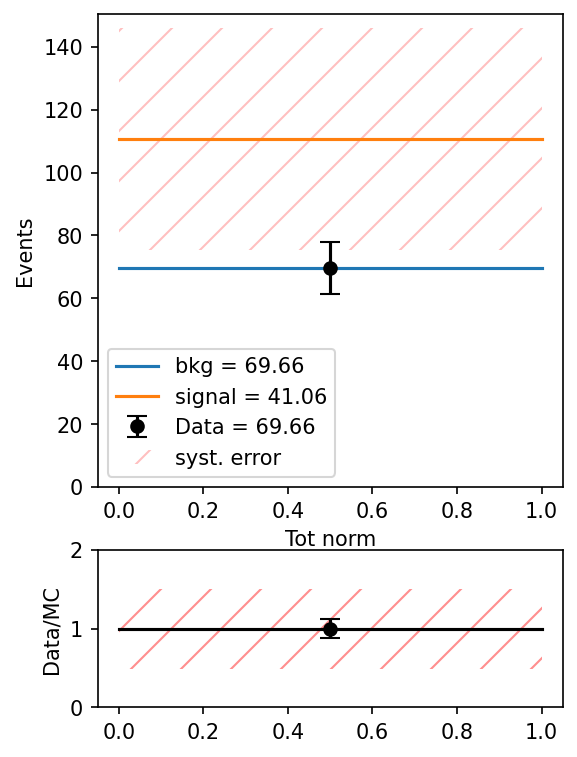

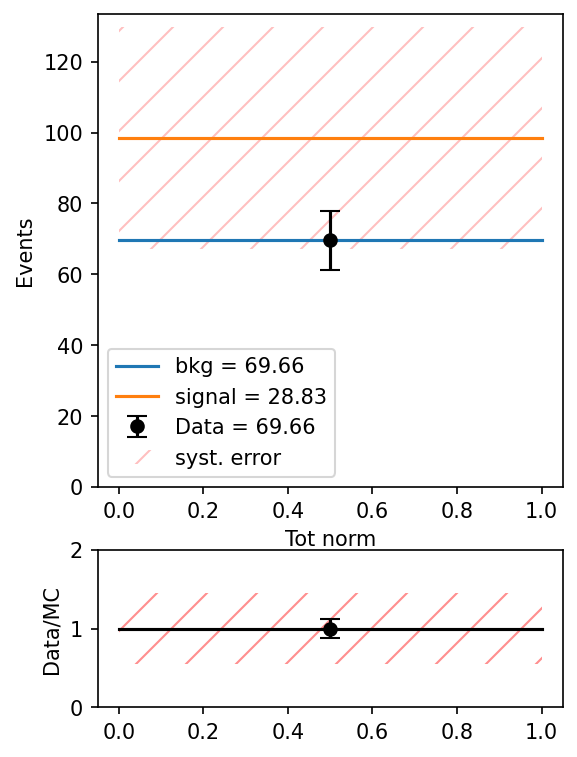

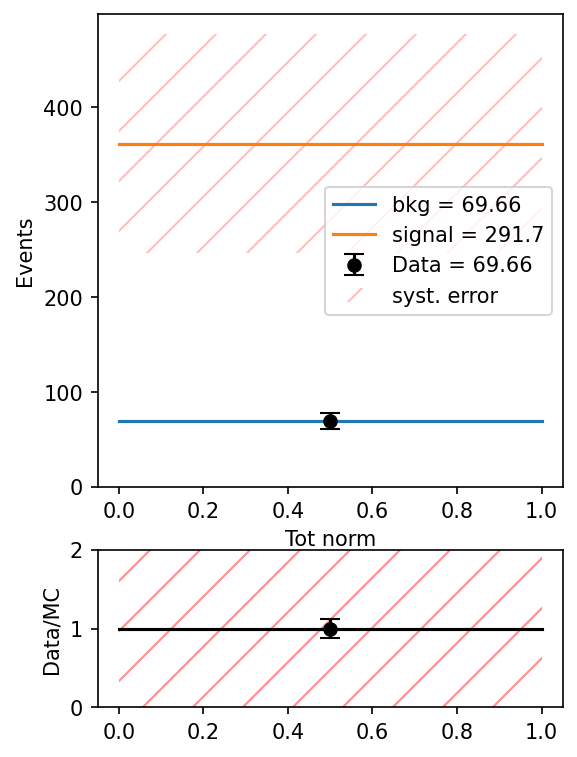

In [20]:
n_signal = get_expected_signal(benchmark_B_decay)

SIG_UNCERT = 0.2
SYST_UNCERT = get_tot_syst(np.array([bkg_uncert, SIG_UNCERT]))

benchmark_arr = [benchmark_A_decay, benchmark_B_decay, benchmark_C_decay, benchmark_D_decay]

for model in benchmark_arr:
    n_signal = get_expected_signal(model)
    syst_abs = (n_signal + bkg_events) * SYST_UNCERT
    fig, ax = plot_single_bin_hist(n_signal, bkg_events, bkg_events, syst_abs)    
    fig.show()

## Implementing a simple pyhf model for a single bin limit 

In [21]:
def create_model_dict_same(Total_dict, debug=False):
    """
    Creating a model where the uncertainties are all enveloped in one shapesys modifier for signal and bkg.
    The total errors are taken from \"TOT_SIGNAL_ERR\" and \"TOT_BKG_ERR\" respectively.
    """
    model_dict = {}
    
    for parameter_point in Total_dict:
        if(debug):print(parameter_point)
        model_dict[parameter_point] = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": Total_dict[parameter_point]['TOT_SIGNAL_VALS'],
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None, }, #This is the scaling which is to be calculated
                {"name": "uncorr_siguncrt", "type": "shapesys", "data": Total_dict[parameter_point]["TOT_SIGNAL_ERR"]}
              ]
            },
            {
              "name": "background",
              "data": Total_dict[parameter_point]['TOT_BKG_VALS'],
              "modifiers": [
                {"name": "uncorr_bkguncrt", "type": "shapesys", "data": Total_dict[parameter_point]["TOT_BKG_ERR"]}
              ]
            }
          ]
        }
      ],
      "parameters": [
            {
                "name": "mu",
                "bounds": [[0, 1000000]],
            }
      ],

    }
    )
    return model_dict

In [26]:
benchmark_A_decay.attrs

{'experiment': <DarkNews.detector.Detector at 0x307fc55d0>,
 'model': <DarkNews.model.ThreePortalModel at 0x3003967a0>,
 'N5_ctau0': 5.313513079050399e-13,
 'data_path': PosixPath('data/microboone/3plus2/m5_0.15_m4_0_mzprime_0.03_dirac')}

In [36]:
Total_dict = {}

names = ['benchmark_A', 'benchmark_B', 'benchmark_C', 'benchmark_D']
i = 0
for model in benchmark_arr:
    
    n_signal = get_expected_signal(model)
    syst_abs = (n_signal + bkg_events) * SYST_UNCERT

    
    Total_dict[names[i]] = {
        'data': [bkg_events],
        'TOT_SIGNAL_VALS': [n_signal],
        'TOT_BKG_VALS': [bkg_events],
        'TOT_SIGNAL_ERR': [syst_abs],
        'TOT_BKG_ERR': [bkg_events_tot_uncert]
    }
    i+=1

model_dict = create_model_dict_same(Total_dict)
DATA_OBS_dict = {}

for model in model_dict:
    init_pars = model_dict[model].config.suggested_init()
    model_dict[model].expected_actualdata(init_pars) #signal plus bkg

    bkg_pars = init_pars.copy()
    bkg_pars[model_dict[model].config.poi_index] = 0
    model_dict[model].expected_actualdata(bkg_pars) #bkg only
    list_keys = list(Total_dict[model].keys())

    DATA_OBS_dict[model] = Total_dict[model]['TOT_BKG_VALS']+model_dict[model].config.auxdata
    
    model_dict[model].logpdf(pars=bkg_pars, data=DATA_OBS_dict[model])


In [39]:
obs_limit_dict = {}
exp_limits_dict = {}
CL_level = 0.95

for model in model_dict:
    poi_values = np.linspace(0,2,100)

    print("Max value is " + str(max(poi_values)))
    print("Min value is " + str(min(poi_values)))
    print("Next value is " + str(poi_values[1]))
    print("Next value is " + str(poi_values[2]) + "\n")

    obs_limit_dict[model], exp_limits_dict[model], (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(
        DATA_OBS_dict[model], model_dict[model], poi_values, level=CL_level, return_results=True
    )

    print(f"Upper limit {model}MeV (obs): μ = {obs_limit_dict[model]:.6f}")
    print(f"Upper limit {model}MeV (exp): μ = {exp_limits_dict[model][2]:.6f}" + "\n")

Max value is 2.0
Min value is 0.0
Next value is 0.020202020202020204
Next value is 0.04040404040404041

Upper limit benchmark_AMeV (obs): μ = 0.041076
Upper limit benchmark_AMeV (exp): μ = 0.041076

Max value is 2.0
Min value is 0.0
Next value is 0.020202020202020204
Next value is 0.04040404040404041

Upper limit benchmark_BMeV (obs): μ = 0.029336
Upper limit benchmark_BMeV (exp): μ = 0.029336

Max value is 2.0
Min value is 0.0
Next value is 0.020202020202020204
Next value is 0.04040404040404041

Upper limit benchmark_CMeV (obs): μ = 0.041810
Upper limit benchmark_CMeV (exp): μ = 0.041810

Max value is 2.0
Min value is 0.0
Next value is 0.020202020202020204
Next value is 0.04040404040404041

Upper limit benchmark_DMeV (obs): μ = 0.004158
Upper limit benchmark_DMeV (exp): μ = 0.004158

